<a href="https://colab.research.google.com/github/hookskl/nlp_w_pytorch/blob/main/nlp_w_pytorch_ch6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequence Modeling for NLP

The core of deep learning with sequences is maintaining hidden "state information", or a *hidden state*. As the model encounters each item of a sequence the hidden state is updated. Because of this, at any time step the hidden state vector, or *sequence representation*, encapsultates everything seen by the model up to that point. This final hidden state can then be used downstream for various NLP tasks, such as input to a linear layer for classification.

## Introduction to Recurrent Neural Networks

The purpose of recurrent neural networks (RNNs) is to model sequences of tensors. The most basic RNN is also referred to as the *Elman RNN*. The goal of the RNN is to learn a representation a sequence. This is done by maintaining a hidden state vector at each time step, which is computed from the current input and previous hidden state.

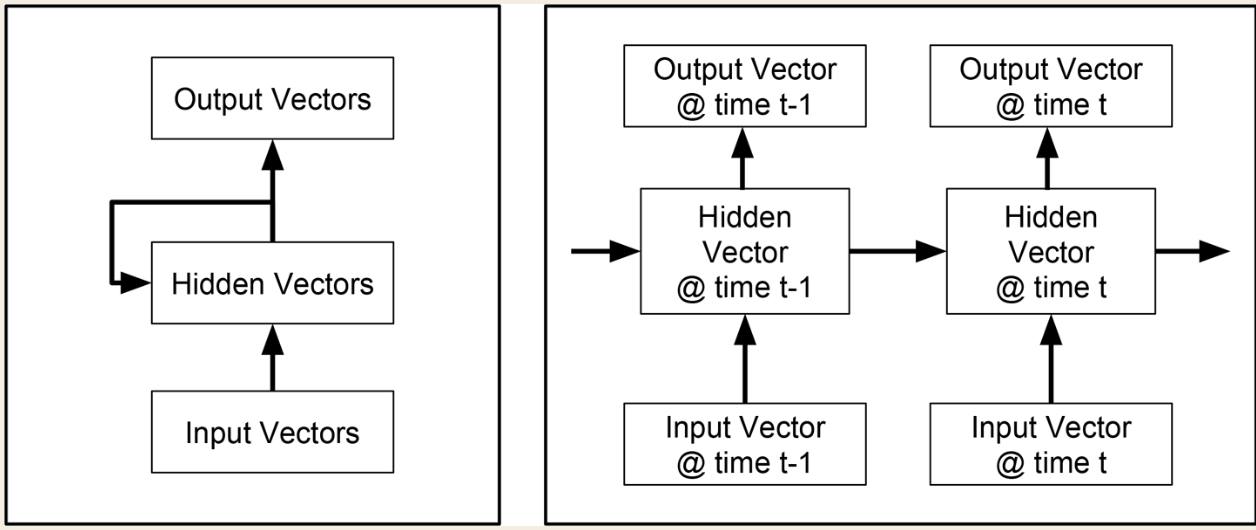

More specifically, the input vector from the current time step and the hidden state vector from the previous time step are mapped to the hidden state vector of the current time step. This new hidden vector is computed using a hidden-to-hidden weight matrix and an input-to-hidden weight matrix.

An important aspect of these matrices is they are shared across the different time steps. The intuition is these weights will be adjusted so that the RNN is learning how to incorporate incoming information and maintain a state representation summarizing the input seen so far. The RNN does know what time step it is, but rather how to transition from one time step to another that will most effectively optimize its loss function.

This use of the same weight matrices is a form of paramter sharing. If CNNs are sharing parameters across space, RNNs share parameters across time.

One note on the mechanics of implementing RNNs is how to handle sequences with variable lengths. One fix is to limit the sequence length artifically. Another, called *masking*, uses information about the lengths of sequences and informs when certian inputs should not count toward the gradient or output. PyTorch provides a primitive for handling variable-length sequences called `PackedSequences`. In essence, `PackedSequences` creates dense tensors from less-dense ones.

### Implementing an Elman RNN

PyTorch offers the `RNN` class to implement the Elman RNN. However, this example will replicate the Elman RNN using the `RNNCell`, an abstraction for a single time step of the RNN. This will demonstrate more explicitly the mechanics of the RNN. The `ElmanRNN` implemented uses the `RNNCell` to create the input-to-hidden and hidden-to-hidden weight matrices. Each call to the `RNNCell` accepts a matrix of input vectors and matrix of hidden vectors. As output it returns the matrix of hidden vectors computed for one time step.

*Example 6-1. An implementation of the Elman RNN using Pytorch's RNNCell* 

```
class ElmanRNN(nn.Module):
    """an Elman RNN built using RNNCell"""
    def __init__(self, input_size, hidden_size, batch_first=False):
        """
        Args:
            input_size (int): size of the input vectors
            hidden_size (int): size of the hidden state vectors
            batch_first (bool): whether the 0th dimension is batch
        """
        super(ElmanRNN, self).__init__()

        self.rnn_cell = nn.RNNCell(input_size, hidden_size)

        self.batch_first = batch_first
        self.hidden_size = hidden_size

        def _initialize_hidden(self, batch_size):
            return torch.zeros((batch_size, self.hidden_size))

        def forward(self, x_in, initial_hidden=None):
            """The forward pass of the ElmanRNN

            Args:
                x_in (torch.Tensor): an input data tensor
                    If self.batch_first: x_in.shape = (batch, seq_size, feat_size)
                    Else: x_in.shape = (seq_size, batch_size, feat_size)
                initial_hidden (torch.tensor): the initial hidden sate for the RNN
            Returns:
                hiddens (torch.Tensor): the outputs of the RNN at each time step.
                    If self.batch_first:
                        hiddens.shape = (batch_size, seq_size, hidden_size)
                    Else: hiddens.shape = (seq_size, batch_size, hidden_size)
            """
            if self.batch_first:
                batch_size, seq_size, feat_size = x_in.size()
                x_in = x_in.permute(1, 0, 2)
            else:
                seq_size, batch_size, feat_size = x_in.size()

            hiddens = []

            if initial_hidden is None:
                initial_hidden = self._initialize_hidden(batch_size)
                initial_hidden = initial_hidden.to(x_in.device)

            hidden_t = initial_hidden

            for t in range(seq_size):
                hidden_t = self.rnn_cell(x_in[t], hidden_t)
                hiddens.append(hidden_t)

            hiddens = torch.stack(hiddens)

            if self.batch_first:
                hiddens = hiddens.permute(1, 0, 2)

            return hiddens
```

The Boolean argument `batch_first` controls whether the dimension will be on the `0`th dimension. This flag is present in all PyTorch RNN implementations. If `True`, the RNN swaps the `0`th and `1`st dimensions of the input tensor.

The `forward()` method loops over the input tensor to compute the hidden state vector for each time step. There is an option for specifying the intial hidden state, with a default set to all `0`s. As the `ElmanRNN` loops over the length of the input vector, it computes a new hidden state. These hidden states are aggregated and stacked at the end. 

The `batch_first` flag is checked again before finally returning a three-dimensional tensor as ouput. This tensor contains a hidden state vector for each data point at each time step of each batch. Several options for how to use this tensor exist, which depends on the task at hand. One example is to classify each time step to some discrete set of options. This will force the RNN weights to track information relevant at each time step. Another example is using the final hidden vector to classify the entire sequence. Doing this will instead force the weights to be adjusted to better track information important for eventual classification.

## Example: Classifying Surname Nationality Using a Character RNN

### The SurnameDataset Class

As before, each surname is treated as a sequence of characters. The dataset class returns the vectorized surname as well as the integer representing its nationality. An addition to this implementation is returning the length of the sequence, which is used downstream to know where the final vector in the sequence is located. 

*Example 6-2. Implementing the SurnameDataset class*

```
class SurnameDataset(Dataset):
    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv):
        """Load dataset and make a new vectorizer from scratch

        Args:
            surname_csv(str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        train_surname_df = surname_df[surname_df.split=='train']
        return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df))

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets

        Args:
            index (int): the index to the data point
        Returns:
            a dictionary holding the data point's:
                features (x_data)
                label (y_target)
                feature length (x_length)
        """
        row = self._target_df.iloc[index]
        surname_vector, vec_length = \
            self._vectorizer.vectorize(row.surname, self._max_seq_length)
        
        nationality_index = \
            self._vectorizer.nationality_vocab.lookup_token(row.nationality)

        return {'x_data': surname_vector,
                'y_target': nationality_index,
                'x_length': vec_length}

```

### The Vectorization Data Structures

The first stage in the vectorization pipeline is to map each character token in the surname to a unique integer. This is accomplished using the `SequenceVocabulary`. This data structure not only maps characters in the names to integers, but also uses four special purpose tokens:

* `UNK`
* `MASK`
* `BEING-OF-SEQUENCE`
* `END-OF-SEQUENCE`

The first two tokens are vital for language data and the latter provide boundary information to the model.

The overall vectorization procedure is managed by the `SurnameVectorizer`, which uses the `SequenceVocabulary` to manage the mapping of characters to integers. The implementation should be very familiar at this point.

*Example 6-3. A vectorizer for surnames*

```
class SurnameVectorizer(object):
    """The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def vectorize(self, surname, vector_length=-1):
        """
        Args:
            title (str): the string of characters
            vector_length (int): an argument for forcing the length of index vector
        """
        indices = [self.char_vocab.begin_seq_index]
        indices.extend(self.char_vocab_lookup_token(token)
                       for token in surname)
        indices.append(self.char_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.char_vocab.mask_index

        return out_vector, len(indices)

    @classmethod
    def from_dataframe(cls, surname_df):
        """Instantiate the vectorizer from the dataset dataframe

        Args:
            surname_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the SurnameVectorizer
        """
        char_vocab = SequenceVocabulary()
        nationality_vocab = Vocabulary()

        for index, row in surname_df.itterrows():
            for char in row.surname:
                char_vocab.add_token(char)
            nationality_vocab.add_token(row.nationality)

        return cls(char_vocab, nationality_vocab)

```

### The SurnameClassifier Model

The `SurnameClassifier` is composed of:

* an embedding layer
* the `ElmanRNN`
* and a `Linear` layer

The input is assumed to be tokens represented as a set of integers after they have been mapped to integers by the `SequenceVocabulary`. This flows into the embedding layer which is then fed into the RNN. Because the goal is to classify each surname (the whole sequence) only the final hidden state vector is extracted. From here, the final hidden state is passed to the linear layer to compute a prediction vector.

Some practical tips for testing the model implementation, it's best to set the model hyperparamters (size of the embeddings and size of the hidden state) to small values first. This lets the model train quickly and verify everything is working.

*Example 6-4. Implementing the SurnameClassifier model using an Elman RNN*

```
class SurnameClassifier(nn.Module):
    """An RNN to extract features & an MLP to classify"""
    def __init__(self, embedding_size, num_embeddings, num_classes,
                 rnn_hidden_size, batch_first=True, padding_idx=0):
        """
        Args:
            embedding_size (int): the size of the character embeddings
            num_embeddings (int): the number of characters to embed
            num_classes (int): the size of the prediction vector
                Note: the number of nationalities
            rnn_hidden_size (int): the size of the RNN's hidden state
            batch_first (bool): informs whether the input tensors will 
                have batch or the sequence on the 0th dimension
            padding_idx (int): the index for the tensor padding;
                see torch.nn.Embedding
        """
        super(SurnameClassifier, self).__init__()

        self.emb = nn.Embedding(num_embeddings=num_embeddings,
                                embedding_dim=embedding_size,
                                padding_idx=padding_idx)
        self.rnn = ElmanRNN(input_size=embedding_size,
                            hidden_size=rnn_hidden_size,
                            batch_first=batch_first)
        self.fc1 = nn.Linear(in_features=rnn_hidden_size,
                             out_features=rnn_hidden_size)
        self.fc2 = nn.Linear(in_features=rnn_hidden_size,
                             out_features=num_classes)

    def forward(self, x_in, x_lengths=None, apply_softmax=False):
        """the forward pass of the classifier

        Args:
            x_in (torch.Tensor): an input data tensor
                x_in.shape should be (batch, input_dim)
            x_lengths (torch.Tensor): the lengths of each sequence in the batch 
                used fo find the final vector of each sequence
            apply_softmax (bool): a flag for the softmax activation
                should be False if used with cross-entropy losses
        Returns:
            out (torch.Tensor): out.shape = (batch, num_classes)
        """
        x_embedded = self.emb(x_in)
        y_out = self.rnn(x_embedded)

        if x_lengths is not None:
            y_out = column_gather(y_out, x_lengths)
        else:
            y_out = y_out[:, -1, :]

        y_out = F.dropout(y_out, 0.5)
        y_out = F.relu(self.fc1(y_out))
        y_out = F.dropout(y_out, 0.5)
        y_out = self.fc2(y_out)

        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)

        return y_out

```

The `forward()` fucntion requires the lengths of the sequences. This is used by a separate function, `column_gather()`, to retrieve the final vector of each sequence in the tensor that is returned by the RNN. This function iterates over bach row indices and retrieves the vector that's at the position indicated by the corresponding length of sequence.

*Example 6-5. Retrieving the final output vector in each sequence using column_gather()*

```
def column_gather(y_out, x_lengths):
    """get a specific vector from each batch data point in `y_out`

    Args:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, sequence, feature)
        x_lengths (torch.LongTensor, torch.cuda.LongTensor)
            shape: (batch,)
        

    Returns:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, feature)
    """
    x_lengths = x_lengths.long().detach().cpu().num() - 1

    out = []
    for batch_index, column_index in enumerate(x_lengths):
        out.append(y_out[batch_index, column_index])
    

    return torch.stack(out)
```

### The Training Routine and Results

The training routine is standard to those implemented previously.

*Example 6-6. Arguments to the RNN-based SurnameClassifer*

```
args = Namespace(
    # Data and path information
    surname_csv="data/surnames/surnames_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="model_storage/ch6/surname_classification",
    # Model hyperparameters
    char_embedding_size=100,
    rnn_hidden_size=64,
    # Training hyperparameters
    num_epochs=100,
    learning_rate=1e-3,
    batch_size=64,
    seed=1337,
    early_stopping_criteria=5,
    # Runtime options omitted
)
```